In [1]:
# make cabin2 into object and number
# just run below

In [2]:
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

In [3]:
def od_ordinal(object_cols, *X_tuple):
    """Takes in X dataframe(s) and a list of column names with object
       data type and returns an ordinal encoded X dataframe(s)."""

    ordinal = OrdinalEncoder()
    for x in X_tuple:
        x[object_cols] = pd.DataFrame(ordinal.fit_transform(x[object_cols]))
    return X_tuple

def od_imputer(numerical_cols, object_cols, *X_tuple):
    """Imputes the numerical and categorical columns of X dataframe(s) before returning the
       said dataframe(s)."""

    imputer_mean = SimpleImputer()
    imputer_mode = SimpleImputer(strategy='most_frequent')

    for x in X_tuple:
        x[numerical_cols] = imputer_mean.fit_transform(x[numerical_cols])
        x[object_cols] = imputer_mode.fit_transform(x[object_cols])
    
    return X_tuple

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

X = train_data.drop(['PassengerId', 'Transported'], axis=1)
y = train_data.Transported
X_test = test_data.drop('PassengerId', axis=1)

# parsing Cabin and Name columns
X[['Cabin', 'Cabin2', 'Cabin3']] = X['Cabin'].str.split('/', expand=True)
X[['First Name', 'Last Name']] = X['Name'].str.split(' ', expand=True)
X_test[['Cabin', 'Cabin2', 'Cabin3']] = X_test['Cabin'].str.split('/', expand=True)
X_test[['First Name', 'Last Name']] = X_test['Name'].str.split(' ', expand=True)
X['Cabin2'] = X['Cabin2'].astype('float')
X_test['Cabin2'] = X_test['Cabin2'].astype('float')

object_cols = [col for col in X.columns if X[col].dtype=='object']
numerical_cols = list(set(X.columns) - set(object_cols))

# preprocessing
X, X_test = od_ordinal(object_cols, X, X_test)
X_test, = od_imputer(numerical_cols, object_cols, X_test)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)
X_train, X_valid = od_imputer(numerical_cols, object_cols, X_train, X_valid)

early_stopping = keras.callbacks.EarlyStopping(min_delta=0.0001,
                                               patience=20,
                                               restore_best_weights=True
)

model = keras.Sequential([layers.BatchNormalization(input_shape=[16]),
                         layers.Dense(1024, activation='relu'),
                         layers.BatchNormalization(),
                         layers.Dropout(rate=0.5),
                         layers.Dense(1024, activation='relu'),
                         layers.BatchNormalization(),
                         layers.Dropout(rate=0.5),
                         layers.Dense(1024, activation='relu'),
                         layers.BatchNormalization(),
                          layers.Dropout(rate=0.5),
                         layers.Dense(1024, activation='relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(rate=0.5),
                          layers.Dense(1024, activation='relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(rate=0.5),
                          layers.Dense(1, activation='sigmoid')
                         ])

model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=['binary_accuracy']
)

fit_object = model.fit(X_train, y_train,
                       epochs=150,
                       batch_size=128,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping],
                       verbose=False
         )

<Axes: >

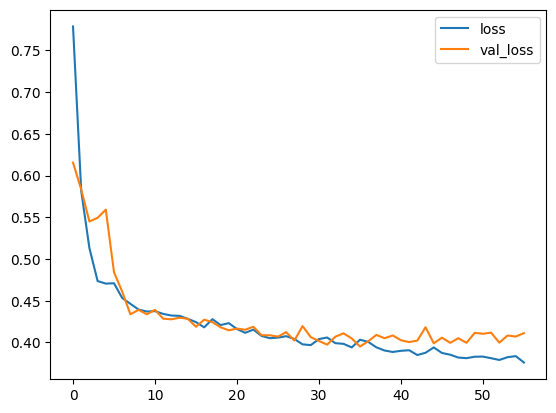

In [6]:
history_df = pd.DataFrame(fit_object.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

In [8]:
yhat_test = np.where(model.predict(X_test).squeeze() >= 0.5, True, False)

output = pd.DataFrame({'PassengerId': test_data.PassengerId,
                       'Transported': yhat_test
})

output.to_csv('submission_nn_val.csv', index=False)

134/134 [==============================] - 1s 9ms/step
